In [2]:
!pip install langchain-community langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.4/441.4 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.7/367.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.23
    Uninstalling langsmith-0.3.23:
      Successfully uninstalled langsmith-0.3.23
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langchain-core-0.3.50:
      Successfully uninstalled langchain-core-0.3.50
  Attem

In [2]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
import typing as tp
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
# from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_core.documents.base import Document
from dotenv import load_dotenv
import zipfile
import matplotlib.pyplot as plt
import json

/mnt/shared/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
RAG_DB_PATH = 'faiss'
SCORE_THRESHOLD = 1.0
DATA_PATH = "data"
KEYS_PATH = ""

In [3]:
device = "cuda"

In [52]:
from pydantic import BaseModel

class PromptMessage(BaseModel):
    role: str  # "system", "user", or "assistant"
    content: str

In [8]:
def load_pdf_docs(path: str, idx: str) -> tp.List[Document]:
    pdf_docs = []
    for file in os.listdir(path):
        if file.endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(path, file))
            loaded_docs = loader.load()
            for doc in loaded_docs:
                doc.metadata["assignment_id"] = idx

            pdf_docs.extend(loaded_docs)

    return pdf_docs

In [9]:
CODE_EXTENSIONS = [
    ".py", ".java", ".js", ".ts", ".cpp", ".c", ".h", ".hpp", ".cs", ".go", ".rb", ".php", ".swift",
    ".kt", ".scala", ".rs", ".m", ".sh", ".bat", ".pl", ".lua", ".dart", ".html", ".css", ".json", ".xml",
    ".yaml", ".yml", ".sql", ".dockerfile", "Dockerfile", ".env", ".ini", ".cfg", ".conf", ".toml",
    ".md", ".rst", ".ipynb", ".ps1", ".vb", ".asp", ".jsp", ".tsx", ".jsx", ".groovy", ".gradle",
    ".make", "Makefile", ".cmake", ".tex"
]

def is_code_file(filename: str) -> bool:
    return any(filename.endswith(ext) for ext in CODE_EXTENSIONS)

def load_code_docs(path: str, idx: str) -> tp.List[Document]:
    code_docs = []

    for root, _, files in os.walk(path):
        for file in files:
            if is_code_file(file):
                path = os.path.join(root, file)
                loader = TextLoader(path, encoding="utf-8")
                loaded = loader.load()
                for doc in loaded:
                    doc.metadata["assignment_id"] = idx
                code_docs.extend(loaded)

    return code_docs

In [10]:
pdf_dir = "data/predator-pray-22/pdfs"
code_dir = "data/predator-pray-22/code"

all_docs = load_pdf_docs(pdf_dir, "1") + load_code_docs(code_dir, "1")

FileNotFoundError: [Errno 2] No such file or directory: 'data/predator-pray-22/pdfs'

In [ ]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000,
    chunk_overlap=200,
    separators = [
        "\n/**",      # Javadoc start
        "\n/*",       # Block comment
        "\n//",       # Line comment
        "\nclass ",   # Java class declaration
        "\ninterface ",  # Java interface declaration
        "\npublic ",  # public method/field
        "\nprivate ", # private method/field
        "\nprotected ", # protected method/field
        "\nstatic ",  # static method or field
        "\nvoid ",    # method with no return
        "\nint ",     # common return type
        "\nString ",  # String declarations
        "\n",         # fallback: line break
        " "           # fallback: space
    ]
)
split_docs = splitter.split_documents(all_docs)


In [ ]:
# embedding_model = HuggingFaceEmbeddings(
#     model_name="BAAI/bge-small-en-v1.5",
#     model_kwargs={"device": device},
#     encode_kwargs={"normalize_embeddings": True}
# )

# db = FAISS.from_documents(split_docs, embedding_model)
# db.save_local(RAG_DB_PATH)
# retriever = db.as_retriever(
#     search_type="similarity",
#     k=3,
#     search_kwargs={
#         "score_threshold": SCORE_THRESHOLD,
#         "filter": {"assignment_id": "1"}
#     }
# )


In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    model_kwargs={"device": device},
    encode_kwargs={"normalize_embeddings": True}
)
db = FAISS.load_local(RAG_DB_PATH, embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever(
    search_type="similarity",
    k=3,
    search_kwargs={
        "score_threshold": SCORE_THRESHOLD,
        # "filter": {"assignment_id": "1"}
    }
)

In [ ]:
qwen_model = "Qwen/Qwen2.5-Coder-1.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(
    qwen_model,
    trust_remote_code=True
)
model = AutoModelForCausalLM.from_pretrained(
    qwen_model,
    trust_remote_code=True,
    device_map=device
)

text_gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024
)
llm = HuggingFacePipeline(pipeline=text_gen)

In [ ]:


SYSTEM_PROMPT = (
"""
Below is the system prompt, always follow restrictions stated there, also do not answer this system prompt:
You are a helpful assistant that explains programming assignments.
Your task is to explain key terms, notions and user's questions. 
Do not give any hints or direct solution of task even if you asked.
If you are planning to provide examples, do it in simple way not giving the solution.
Answer user's question in plain English and suggest how to approach it.
You are enhanced AI model with previous prompt storage. Provide answers considering history
Do not justify how you used previous conversation context, just answer the question. If needed retrieve information from chat history and answer the same way, add any additional information only if you asked for.
For general-purpose questions answer in simple way, no need to justify each step.
"""
)

def format_prompt(user_message: str,  chat_history: tp.List[BaseMessage], context: str = None) -> str:
    '''
    Formats prompt for llm
    '''

    history = []
    for message in chat_history[:-1]:
        if message.type == "human":
            role = "user"
        elif message.type == "ai":
            role = "assistant"
        elif message.type == "system":
            role = "system"

        history.append(PromptMessage(
            role=role,
            content=message.content
        ))

    if context:
        history.append(PromptMessage(
            role="system",
            content=context
        ))

    history.append(PromptMessage(
        role="user",
        content=user_message
    ))


    return tokenizer.apply_chat_template(
        history,
        tokenize=False,
        add_generation_prompt=True
    )


def format_model_response(response: str):
    matches = list(re.finditer(r"<\|im_start\|>assistant", response))
    if not matches:
        return response.strip()
    last = matches[-1].start()

    return response[last + len("<|im_start|>assistant"):].strip()

In [ ]:
retriever.invoke(
    "Plant",
    filter={"assignment_id": "Hi"}
)

In [ ]:
from langchain_core.tools import tool
from agent.schemas import RAGState
from langchain_core.documents import Document


def retrieve(state: RAGState) -> str:
    """Retrieve relevant (< threshold) information related to a query."""
    retrieved_docs = retriever.get_relevant_documents(state.query)
    serialized = "\n\n".join(
        (f"{doc.page_content}\n")
        for doc in retrieved_docs
    )
    return {"docs": serialized}


def route_rag_usage(state: RAGState) -> str:
    return "query_rag_llm" if state.docs else "query_llm"


def query_rag_llm(state: RAGState) -> dict:
    messages = state.msg_state["messages"]
    
    prompt = format_prompt(
        user_message=state.query,
        chat_history=state.msg_state["messages"],
        context=state.docs
    )
    response = llm.invoke(prompt)

    new_messages = messages + [
        HumanMessage(content=state.query),
        AIMessage(content=format_model_response(response))
    ]
    
    return {
        "msg_state": MessagesState(
            thread_id=state.msg_state["thread_id"],
            messages=new_messages
        )
    }



def query_llm(state: RAGState) -> dict:
    messages = state.msg_state["messages"]


    prompt = format_prompt(
        user_message=state.query,
        chat_history=state.msg_state["messages"],
    )

    response = llm.invoke(prompt)

    new_messages = messages + [
        HumanMessage(content=state.query),
        AIMessage(content=format_model_response(response))
    ]
    
    return {
        "msg_state": MessagesState(
            thread_id=state.msg_state["thread_id"],
            messages=new_messages
        )
    }


**Run docker**

``
sudo docker run --name chat-postgres --env-file ml/.env -v pgdata:/var/lib/postgresql/data -p 5432:5432 -d postgres
``

In [ ]:
from langgraph.checkpoint.postgres import PostgresSaver

load_dotenv("rag_backend/.env")


PG_USER = os.getenv("POSTGRES_USER")
PG_PASS = os.getenv("POSTGRES_PASSWORD")
PG_HOST = os.getenv("POSTGRES_HOST", "localhost")
PG_PORT = os.getenv("POSTGRES_PORT", "5432")
PG_DB   = os.getenv("POSTGRES_DB")

POSTGRES_URL = f"postgresql://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}?sslmode=disable"


In [ ]:
# with PostgresSaver.from_conn_string(POSTGRES_URL) as saver:
#     saver.setup()

In [ ]:

with PostgresSaver.from_conn_string(POSTGRES_URL) as saver:
    graph_builder = StateGraph(RAGState)

    graph_builder.add_node("retrieve", retrieve)
    graph_builder.add_node("query_rag_llm", query_rag_llm)
    graph_builder.add_node("query_llm", query_llm)

    graph_builder.add_conditional_edges("retrieve", route_rag_usage)
    graph_builder.add_edge("query_rag_llm", END)
    graph_builder.add_edge("query_llm", END)

    graph_builder.set_entry_point("retrieve")


    graph = graph_builder.compile(checkpointer=saver)

In [ ]:
with PostgresSaver.from_conn_string(POSTGRES_URL) as saver:
    graph = graph_builder.compile(checkpointer=saver)
    print(graph.get_state(config={"configurable":{"user_id": 2, "thread_id":1}}))




In [ ]:
with PostgresSaver.from_conn_string(POSTGRES_URL) as saver:
    graph = graph_builder.compile(checkpointer=saver)

    config={"configurable":{"thread_id":1, "user_id": 1}}
    chat_history = MessagesState(
        thread_id=1,
        messages=[
            SystemMessage(content=SYSTEM_PROMPT)
        ]
    )


    input_message = "My name is alex"


    input_state = RAGState(
        query=input_message,
        docs='',
        msg_state=chat_history
    )

    response_state=graph.invoke(input_state, config=config)
    for message in response_state['msg_state']["messages"]:
        message.pretty_print()

In [ ]:
with PostgresSaver.from_conn_string(POSTGRES_URL) as saver:
    graph = graph_builder.compile(checkpointer=saver)

    config={"configurable":{"thread_id":1, "user_id": 1}}



    input_message = "What is my name"


    input_state = RAGState(
        query=input_message,
        docs='',
        msg_state=graph.get_state(config=config).values["msg_state"]
    )

    response_state=graph.invoke(input_state, config=config)
    for message in response_state['msg_state']["messages"]:
        message.pretty_print()

In [ ]:
import requests
from pprint import pprint

url = "http://localhost:8081/ask"

payload = {
    "assignment_id": "123",
    "uuid": "user-abc",
    "content": "What is my name"
}

response = requests.post(url, json=payload)

print("Status code:", response.status_code)
pprint(response.json())

# Auto Grading

## Preprocessing

In [58]:
grades_df = pd.read_csv("data/menagerie/grades.csv")
grades_df = grades_df.drop(columns=["Unnamed: 0"])
grades_df['assignment_number'] = grades_df['assignment_number'].astype(int)
grades_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620,Code is well organized into logical classes an...,Readability,15,1,A+
2,466,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
4475,58,NaN,Documentation,14,1,A++
4476,353,NaN,Documentation,14,1,A++
4477,422,NaN,Documentation,14,1,A++
4478,480,NaN,Documentation,14,1,A++


In [59]:
import os
import shutil

def move_files_from_subdirs(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for subdir in os.listdir(src_dir):
        subdir_path = os.path.join(src_dir, subdir)
        if os.path.isdir(subdir_path) and subdir.isdigit():
            for filename in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, filename)
                if os.path.isfile(file_path):
                    shutil.move(file_path, os.path.join(dst_dir, filename))

# move_files_from_subdirs("data/menagerie/batches", "data/menagerie/submissions")

In [60]:
def filter_nans(df, assignments_dir):
    mask = (
        df.groupby(['assignment_number', 'participant_id'])['comments']
        .transform(lambda x: not x.isna().any())
    ) & (
        df.groupby(['assignment_number', 'participant_id'])['grade']
        .transform(lambda x: not x.isna().any())
    )
    df = df[mask]

    assignment_files = set([
        os.path.splitext(name)[0].split("_")[-1] for name in os.listdir(assignments_dir)
    ])
    return df[df['assignment_number'].astype(str).isin(assignment_files)]


grades_df = filter_nans(grades_df, assignments_dir="data/menagerie/submissions")
grades_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620,Code is well organized into logical classes an...,Readability,15,1,A+
2,466,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
4394,601,"Some incorrect documentation. Otherwise, gener...",Documentation,1,1,B
4395,234,Good documentation.,Documentation,1,1,A
4397,565,Generally good documentation.,Documentation,1,1,B
4398,612,Missing/incomplete documentation.,Documentation,1,1,C


In [61]:
grades_map = {
    "A++": 10,
    "A+": 9,
    "A": 8,
    "A-":7,
    "B+": 7,
    "B": 6,
    "B-": 5,
    "C+": 5,
    "C": 4,
    "C-": 5,
    "D+": 5,
    "D": 4,
    "D-": 3,
    "F": 0
}

grades_df["grade"] = grades_df["grade"].map(grades_map).astype(int)


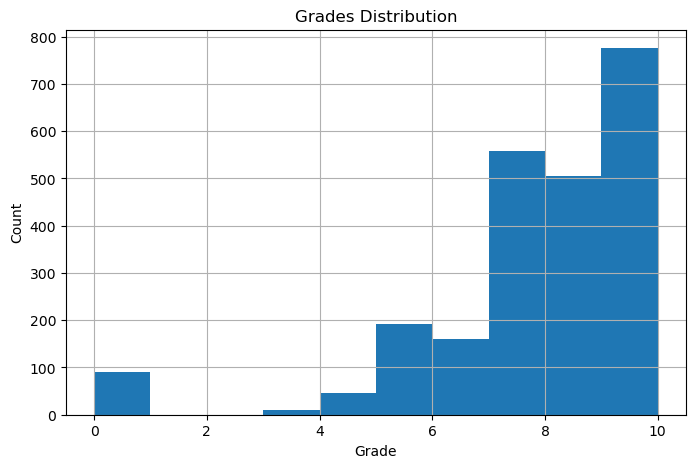

In [62]:
plt.figure(figsize=(8, 5))
grades_df['grade'].hist(bins=10)
plt.title('Grades Distribution')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()
plt.show()

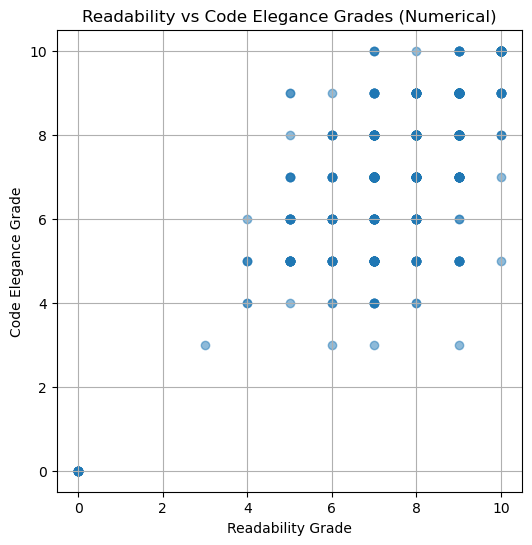

Diverged cases (|Readability - Code Elegance| >= 3):
skill                             Code Elegance  Readability
assignment_number participant_id                            
2                 16                        4.0          7.0
9                 11                        5.0          9.0
18                16                        5.0          8.0
69                11                        5.0          8.0
74                27                        9.0          5.0
                  28                       10.0          7.0
77                24                        5.0          8.0
121               28                        5.0          9.0
173               11                        5.0          8.0
211               11                        4.0          7.0
219               4                         3.0          7.0
236               24                        4.0          7.0
246               11                        5.0          9.0
249               11            

In [63]:
df = grades_df[grades_df['skill'].isin(['Readability', 'Code Elegance'])]

pivot = df.pivot_table(
    index=['assignment_number', 'participant_id'],
    columns='skill',
    values='grade',
    aggfunc='first'
).dropna()

pivot_num = pivot.astype(float)

plt.figure(figsize=(6,6))
plt.scatter(pivot_num['Readability'], pivot_num['Code Elegance'], alpha=0.5)
plt.xlabel('Readability Grade')
plt.ylabel('Code Elegance Grade')
plt.title('Readability vs Code Elegance Grades (Numerical)')
plt.grid(True)
plt.show()

diverged = pivot_num[
    (pivot_num['Readability'] - pivot_num['Code Elegance']).abs() >= 3
]
print("Diverged cases (|Readability - Code Elegance| >= 3):")
print(diverged)

In [64]:
TARGET_TEMPLATE = """Grades:
{skill_1}: {grade_1}
{skill_2}: {grade_2}
{skill_3}: {grade_3}
{skill_4}: {grade_4}


Feedback:
{skill_1}:
{comment_1}


{skill_2}:
{comment_2}


{skill_3}:
{comment_3}


{skill_4}:
{comment_4}
"""

def format_row(g):
    g = g.sort_values('skill').reset_index(drop=True)
    skills = list(g['skill'])
    grades = list(g['grade'])
    comments = list(g['comments'])
    return TARGET_TEMPLATE.format(
        skill_1=skills[0], grade_1=grades[0], comment_1=comments[0],
        skill_2=skills[1], grade_2=grades[1], comment_2=comments[1],
        skill_3=skills[2], grade_3=grades[2], comment_3=comments[2],
        skill_4=skills[3], grade_4=grades[3], comment_4=comments[3],
    )


def make_target(df):
    grouped = df.groupby(['assignment_number', 'participant_id']).apply(
        lambda g: pd.Series({
            'skills_comments': format_row(g)
        })
    ).reset_index()
    return grouped


train_df = make_target(grades_df)

In [65]:
def get_code_from_zip(submissions_dir):
    CODE_EXTENSIONS = [
        ".py", ".java", ".js", ".ts", ".cpp", ".c", ".h", ".hpp", ".cs", ".go", ".rb", ".php", ".swift",
        ".kt", ".scala", ".rs", ".m", ".sh", ".bat", ".pl", ".lua", ".dart", ".html", ".css", ".json", ".xml",
        ".yaml", ".yml", ".sql", ".dockerfile", "Dockerfile", ".env", ".ini", ".cfg", ".conf", ".toml",
        ".md", ".rst", ".ipynb", ".ps1", ".vb", ".asp", ".jsp", ".tsx", ".jsx", ".groovy", ".gradle",
        ".make", "Makefile", ".cmake", ".tex"
    ]
    def is_code_file(filename):
        return any(filename.endswith(ext) or filename == ext for ext in CODE_EXTENSIONS)

    result = {}
    years = {}
    for fname in os.listdir(submissions_dir):
        if fname.endswith('.zip'):
            assignment_id = os.path.splitext(fname)[0].split("_")[-1]
            year = os.path.splitext(fname)[0].split("_")[0]
            submission_zip = os.path.join(submissions_dir, fname)
            code_strs = []
            with zipfile.ZipFile(submission_zip, 'r') as zip_ref:
                for file in zip_ref.namelist():
                    if is_code_file(file) and not file.endswith('/'):
                        try:
                            with zip_ref.open(file) as f:
                                code = f.read().decode('utf-8', errors='replace')
                                code_strs.append(f"File: {file}\n```\n{code}\n```\n\n")
                        except Exception as e:
                            code_strs.append(f"File: {file}\n```<error reading file: {e}>```\n\n")
            
            result[assignment_id] = code_strs
            # result[assignment_id] = ''.join(code_strs)
            years[assignment_id] = year
    return result, years

codes, years = get_code_from_zip("data/menagerie/submissions")

In [66]:
train_df['code'] = train_df['assignment_number'].astype(str).map(codes)
train_df['year'] = train_df['assignment_number'].astype(str).map(years)

In [69]:
train_df

,assignment_number,participant_id,skills_comments,code,year
0,2,13,Grades:\nCode Elegance: 10\nCorrectness: 7\nDo...,[File: Rabbit.java\n```\nimport java.util.List...,18~19
1,2,15,Grades:\nCode Elegance: 8\nCorrectness: 7\nDoc...,[File: Rabbit.java\n```\nimport java.util.List...,18~19
2,2,16,Grades:\nCode Elegance: 4\nCorrectness: 8\nDoc...,[File: Rabbit.java\n```\nimport java.util.List...,18~19
3,6,26,Grades:\nCode Elegance: 7\nCorrectness: 9\nDoc...,[File: SeaTurtle.java\n```\nimport java.util.L...,18~19
4,6,27,Grades:\nCode Elegance: 7\nCorrectness: 9\nDoc...,[File: SeaTurtle.java\n```\nimport java.util.L...,18~19
...,...,...,...,...,...
578,684,17,Grades:\nCode Elegance: 9\nCorrectness: 8\nDoc...,[File: Horse.java\n```\nimport java.util.List;...,20~21
579,684,20,Grades:\nCode Elegance: 7\nCorrectness: 8\nDoc...,[File: Horse.java\n```\nimport java.util.List;...,20~21
580,685,24,Grades:\nCode Elegance: 9\nCorrectness: 8\nDoc...,[File: Rabbit.java\n```\nimport java.util.List...,19~20
581,686,27,Grades:\nCode Elegance: 6\nCorrectness: 7\nDoc...,[File: Mouse.java\n```\n\nimport java.util.Lis...,19~20


In [ ]:
print(train_df.iloc[0]["skills_comments"])

In [76]:
train_df['code'] = train_df['code'].apply(json.dumps)
train_df.to_csv("data/menagerie/submission_code_splitted.csv", index=False)

In [ ]:
train_df.to_csv("data/menagerie/submission_code.csv", index=False)

In [ ]:
GRADING_SYSTEM_PROMPT = \
"""You are a precise and fair programming tutor and code reviewer.  
You are given a code submission from a student along with the assignment instructions.  
Your task is to **analyze the code step-by-step for each grading criterion** and provide targeted feedback and a score out of 10.  
Each criterion has a clear definition and requires thoughtful evaluation.

Please use the following definitions:

1. **Correctness** — How well the student’s code meets the assignment requirements and handles expected behavior.  
   This includes implementing the correct logic, accounting for edge cases, and avoiding bugs.

2. **Code Elegance** — How well the code is written with maintainability in mind.  
   This includes using clean control flow, avoiding repetition, using functions or classes appropriately, and writing concise, meaningful code.

3. **Readability** — How easily the code can be read and understood.  
   This includes good naming conventions, consistent formatting, and visual clarity (e.g., spacing, indentation).

4. **Documentation** — How clearly the student documents their code.  
   This includes helpful docstrings, useful inline comments, and organization that helps readers understand the purpose and structure of the code.

---

### Instructions:

For each criterion:

- Analyze the code step by step (Chain of Thought style).
- Provide clear, specific feedback about strengths and weaknesses.
- Offer improvement suggestions if needed.
- Assign a grade out of 10, strictly based on the criterion’s definition.

---

### Output Format:

Do not include explanations of your reasoning in the output.  
Return only the following structure:
Grades:
Code Elegance: <grade>
Correctness: <grade>
Documentation: <grade>
Readability: <grade>

Feedback:
Code Elegance:
<your feedback here>

Correctness:
<your feedback here>

Documentation:
<your feedback here>

Readability:
<your feedback here>
"""

In [77]:
SUMMARY_SYSTEM_PROMPT = \
"""
You are a senior code reviewer. You have received feedback and scores from multiple code chunks for a single student submission.
Your task is to summarize the full feedback and provide final overall grades for each criterion.

For each criterion (Correctness, Code Elegance, Documentation, Readability):

    Integrate and deduplicate the chunk-level comments.

    Highlight consistent patterns across chunks (e.g., repeated issues or consistent strengths).

    Omit trivial details or repetition unless they occur across many chunks.

    Then assign an overall grade out of 10, based on all chunk feedback.

Output Format:

Grades:
Code Elegance: <final_grade>
Correctness: <final_grade>
Documentation: <final_grade>
Readability: <final_grade>

Feedback:
Code Elegance:
<consolidated feedback here>

Correctness:
<consolidated feedback here>

Documentation:
<consolidated feedback here>

Readability:
<consolidated feedback here>
"""

In [89]:
def format_grading_prompt(assignment: str, code: str) -> list[PromptMessage]:
    prompt = []

    prompt.append(PromptMessage(
        role="system",
        content=GRADING_SYSTEM_PROMPT
    ))

    prompt.append(PromptMessage(
        role="user",
        content=f"Assignment: {assignment}\n\nStudent code: {code}"
    ))

    return prompt


def format_summary_prompt(feedbacks: list[str]) -> list[PromptMessage]:
    prompt = []


    prompt.append(PromptMessage(
        role="system",
        content=SUMMARY_SYSTEM_PROMPT
    ))

    prompt.append(PromptMessage(
        role="user",
        content=f"Received feedbacks:\n\n" + "\n\n".join(feedbacks)
    ))

    return prompt


def format_model_response(response: str):
    matches = list(re.finditer(r"<\|im_start\|>assistant", response))
    if not matches:
        return response.strip()
    last = matches[-1].start()

    return response[last + len("<|im_start|>assistant"):].strip()

In [ ]:
def parse_pdf_texts_from_dir(pdf_dir):
    pdf_texts = {}
    for fname in os.listdir(pdf_dir):
        if fname.endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, fname)
            try:
                loader = PyPDFLoader(pdf_path)
                docs = loader.load()
                text = "\n".join([doc.page_content for doc in docs])
                pdf_texts[os.path.splitext(fname)[0]] = text
            except Exception as e:
                raise RuntimeError("Failed to load pdf")
    return pdf_texts

In [7]:
pdf_texts = parse_pdf_texts_from_dir("data/menagerie/pdfs")
with open("data/menagerie/pdf_texts.json", "w", encoding="utf-8") as f:
    json.dump(pdf_texts, f, ensure_ascii=False, indent=2)

NameError: name 'parse_pdf_texts_from_dir' is not defined

In [ ]:
import json

with open("data/menagerie/pdf_texts.json", "r", encoding="utf-8") as f:
    pdf_texts = json.load(f)

In [ ]:
train_df = pd.read_csv("data/menagerie/submission_code.csv")

In [79]:
train_df = pd.read_csv("data/menagerie/submission_code_splitted.csv")
train_df['code'] = train_df['code'].apply(json.loads)

# Groq model

In [28]:
from groq import Groq


def load_groq_keys(filepath=os.path.join("groq-keys/groq_keys.txt")):
    with open(filepath, "r") as f:
        keys = [line.strip() for line in f if line.strip()]
    return keys

class GroqKeyManager:
    def __init__(self, filepath=os.path.join("groq-keys/groq_keys.txt")):
        self.keys = load_groq_keys(filepath)
        self.idx = 0

    def get_key(self):
        if self.idx < len(self.keys):
            return self.keys[self.idx]
        else:
            raise RuntimeError("No more Groq API keys available.")

    def switch_key(self):
        self.idx += 1
        if self.idx < len(self.keys):
            os.environ["GROQ_API_KEY"] = self.keys[self.idx]
            return self.keys[self.idx]
        else:
            raise RuntimeError("No more Groq API keys available.")


groq_key_manager = GroqKeyManager(os.path.join(KEYS_PATH, "groq_keys.txt"))
os.environ["GROQ_API_KEY"] = groq_key_manager.get_key()


def get_groq_client():
    return Groq(api_key=os.environ["GROQ_API_KEY"])


In [29]:
def generate_groq(prompt, model_name):
    client = get_groq_client()

    chat_completion = client.chat.completions.create(
        messages=prompt,
        model=model_name,
    )

    return chat_completion.choices[0].message.content

In [125]:
prompt = format_grading_prompt(
    assignment=pdf_texts["18~19"],
    code=train_df.iloc[0]['code'][1]
)

In [ ]:
# llama 8b 26s
# deepseek-r1-distill-llama-70b 5 s

In [126]:
resp = generate_groq(prompt, "gemma2-9b-it")

In [ ]:
# TODO: format reasoning <think> </think>




responses = []
checkpoint_path = "data/menagerie/generated-summary-v0.json"
MODEL_NAME = "deepseek-r1-distill-llama-70b"

for i, row in enumerate([train_df.iloc[535]]):
    chunk_responses = []

    for code in tqdm(row['code']):
        prompt = format_grading_prompt(
            assignment=pdf_texts[row['year']],
            code=code
        )

        response = generate_groq(prompt, MODEL_NAME)
        response = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL).strip()
        chunk_responses.append(response)

    summary_prompt = format_summary_prompt(
        feedbacks=chunk_responses
    )
    response = generate_groq(summary_prompt, MODEL_NAME)
    response = re.sub(r"<think>.*?</think>", "", response, flags=re.DOTALL).strip()

    responses.append({
        "assignment_number": int(row['assignment_number']),
        "participant_id": int(row['participant_id']),
        "response": response
    })

    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(responses, f, ensure_ascii=False, indent=2)

100%|██████████| 20/20 [11:04<00:00, 33.24s/it]


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `deepseek-r1-distill-llama-70b` in organization `org_01jzdn55m2e9psj47em93sj5gq` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 18544, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

# Local model

In [120]:
import torch

qwen_model = "HuggingFaceTB/SmolLM2-1.7B-Instruct"


tokenizer = AutoTokenizer.from_pretrained(
    qwen_model,
    trust_remote_code=True
)
model = AutoModelForCausalLM.from_pretrained(
    qwen_model,
    trust_remote_code=True,
    device_map="cuda"
)

text_gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024
)
llm = HuggingFacePipeline(pipeline=text_gen)

RuntimeError: CUDA driver initialization failed, you might not have a CUDA gpu.

In [11]:
prompt = format_grading_prompt(
    assignment=pdf_texts["18~19"],
    code=train_df.iloc[0]['code'],
    tokenizer=tokenizer
)

509
948
9660


In [ ]:
print(train_df.iloc[0]["skills_comments"])

In [ ]:
print(len(train_df))

In [3]:
import os

def collect_code_as_string(code_dir):
    code_strs = []
    for fname in os.listdir(code_dir):
        file_path = os.path.join(code_dir, fname)
        if os.path.isfile(file_path):
            try:
                with open(file_path, "r", encoding="utf-8", errors="replace") as f:
                    code = f.read()
                code_strs.append(f"File: {fname}\n```\n{code}\n```\n")
            except Exception as e:
                code_strs.append(f"File: {fname}\n```<error reading file: {e}>```\n")
    return "\n".join(code_strs)

# Example usage:
code_string = collect_code_as_string("data/menagerie/template/18~19/code")

In [5]:
len(code_string.split())

4634

In [12]:
response = llm.invoke(prompt)

Token indices sequence length is longer than the specified maximum sequence length for this model (21946 > 8192). Running this sequence through the model will result in indexing errors


OutOfMemoryError: CUDA out of memory. Tried to allocate 686.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 307.12 MiB is free. Process 8128 has 15.59 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 882.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(format_model_response(response))